In [1]:
import numpy as np
import pandas as pd
import timeit
import time
import matplotlib.pyplot as plt
import random
import scipy.io

In [2]:
import tensorflow.compat.v1 as tf
from tqdm import tqdm
import timeit 
tf.disable_v2_behavior()

2023-08-08 12:37:07.473402: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-08 12:37:07.475161: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 12:37:07.507827: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 12:37:07.508299: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 12:37:08.277906: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
dat1 =pd.read_csv('data120.csv')
dat1.head()

,t,u1,u2,u3
0,0.0,0.000000,0.000000,1.000000
1,0.1,0.055747,0.335719,0.606531
2,0.2,0.166850,0.452330,0.367879
3,0.3,0.282767,0.458599,0.223130
4,0.4,0.381125,0.414647,0.135335


In [4]:
z1_new = np.array(dat1["u1"]).flatten()[:,None]
z2_new = np.array(dat1["u2"]).flatten()[:,None]
z3_new = np.array(dat1["u3"]).flatten()[:,None]
t_new = np.array(dat1["t"]).flatten()[:,None]

In [5]:
from scipy import interpolate

# Assuming that the 't_data' array is the independent variable and 'z1_data' and 'z2_data' are dependent variables
t_data = np.linspace(t_new.min(), t_new.max(), 100)[:, None]  # generating 500 points

# Interpolation for z1_data
f_z1 = interpolate.interp1d(t_new.flatten(), z1_new.flatten(), kind='cubic')  # 'cubic' for cubic spline interpolation
z1_data = f_z1(t_data)

# Interpolation for z2_data
f_z2 = interpolate.interp1d(t_new.flatten(), z2_new.flatten(), kind='cubic')  # 'cubic' for cubic spline interpolation
z2_data = f_z2(t_data)

# Interpolation for z3_data
f_z3 = interpolate.interp1d(t_new.flatten(), z3_new.flatten(), kind='cubic')  # 'cubic' for cubic spline interpolation
z3_data = f_z3(t_data)

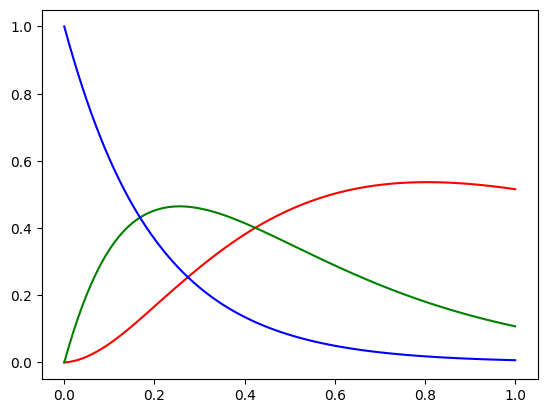

In [6]:
plt.plot(t_data, z1_data,"r")
plt.plot(t_data, z2_data,"g-")
plt.plot(t_data, z3_data,"b-")

plt.show()

In [7]:
class PINN:
    # Initialize the class
    def __init__(self, t, z1, z2, z3, layers, layers1, layers2, layers3):
        
        self.lb = t.min(0)
        self.ub = t.max(0)
        
        self.t = t
        
        self.z1 = z1
        self.z2 = z2
        self.z3 = z3
        
        self.layers = layers
        self.layers1 = layers1
        self.layers2 = layers2
        self.layers3 = layers3
        
        self.weights, self.biases = self.initialize_NN(layers)
        self.weights1, self.biases1 = self.initialize_NN(layers1)
        self.weights2, self.biases2 = self.initialize_NN(layers2)
        self.weights3, self.biases3 = self.initialize_NN(layers3)
        
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        
        
        
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.z1_tf = tf.placeholder(tf.float32, shape=[None, self.z1.shape[1]])
        self.z2_tf = tf.placeholder(tf.float32, shape=[None, self.z2.shape[1]])
        self.z3_tf = tf.placeholder(tf.float32, shape=[None, self.z3.shape[1]])
        
        
        
        self.z1_pred, self.z2_pred, self.z3_pred = self.net_ASIR(self.t_tf)
        self.aa_pred = self.aa_net(self.t_tf)
        self.bb_pred = self.bb_net(self.t_tf)
        self.cc_pred = self.cc_net(self.t_tf)
        
        self.l1, self.l2, self.l3 = self.net_l(self.t_tf)
        
        
        self.loss = tf.reduce_sum(tf.square(self.z1_tf - self.z1_pred)) + \
                    tf.reduce_sum(tf.square(self.z2_tf - self.z2_pred)) + \
                    tf.reduce_sum(tf.square(self.z3_tf - self.z3_pred)) + \
                    tf.reduce_sum(tf.square(self.l1)) + \
                    tf.reduce_sum(tf.square(self.l2)) + \
                    tf.reduce_sum(tf.square(self.l3))
        
        #self.train_op = tf.train.AdamOptimizer().minimize(self.loss)
        self.optimizer = tf.train.AdamOptimizer(1e-3)
        self.train_op = self.optimizer.minimize(self.loss)
        self.loss_log = []
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, t, layers, weights, biases):
        num_layers = len(layers1)
        
        H = 2.0*(t - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
        
    def neural_net1(self, t, layers1, weights1, biases1):
        num_layers = len(layers1)
        
        H = 2.0*(t - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights1[l]
            b = biases1[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights1[-1]
        b = biases1[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def neural_net2(self, t, layers2, weights2, biases2):
        num_layers = len(layers1)
        
        H = 2.0*(t - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights2[l]
            b = biases2[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights2[-1]
        b = biases2[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    
    def neural_net3(self, t, layers3, weights3, biases3):
        num_layers = len(layers1)
        
        H = 2.0*(t - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights3[l]
            b = biases3[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights3[-1]
        b = biases3[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    
    def net_ASIR(self, t):
        ASIR = self.neural_net(t, self.layers, self.weights, self.biases)
        z1 = ASIR[:,0:1]
        z2 = ASIR[:,1:2]
        z3 = ASIR[:,2:3]
        
        return z1, z2, z3
    
    def aa_net(self,t):
        aa = self.neural_net1(t, self.layers1, self.weights1, self.biases1)
        alp = aa
        return alp
    
    def bb_net(self,t):
        bb = self.neural_net2(t, self.layers2, self.weights2, self.biases2)
        blp = bb
        return blp
    
    def cc_net(self,t):
        cc = self.neural_net2(t, self.layers3, self.weights3, self.biases3)
        clp = cc
        return clp
    
    
    
    def net_l(self, t):
        z1, z2, z3 = self.net_ASIR(t)
        aa = self.aa_net(t)
        bb = self.bb_net(t)
        cc = self.cc_net(t)
        
        z1_t = tf.gradients(z1, t)[0]
        z2_t = tf.gradients(z2, t)[0]
        z3_t = tf.gradients(z3, t)[0]
        
        


        
        l1 = z1 - (15/8 * (tf.exp(-cc * t) - 2 * tf.exp(-bb * t) + tf.exp(-aa * t)))
        l2 = z2 - (5 / 2 * (- tf.exp(-cc * t) + tf.exp(-bb * t)))
        l3 = z3 - (tf.exp(-cc * t))
        
        return l1, l2, l3
    
    
        
        
    def train(self, nIter):
        tf_dict = {self.t_tf: self.t, self.z1_tf: self.z1, self.z2_tf: self.z2, self.z3_tf: self.z3}
        start_time = timeit.default_timer()

        for it in tqdm(range(nIter)):
            self.sess.run(self.train_op, tf_dict)
            if it % 100 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                self.loss_log.append(loss_value)
                start_time = timeit.default_timer()
                
    def predict(self, t_star):
        tf_dict = {self.t_tf: t_star}
        
        z1_star = self.sess.run(self.z1_pred, tf_dict)
        z2_star = self.sess.run(self.z2_pred, tf_dict)
        z3_star = self.sess.run(self.z3_pred, tf_dict)
        aa_star = self.sess.run(self.aa_pred, tf_dict)
        bb_star = self.sess.run(self.bb_pred, tf_dict)
        cc_star = self.sess.run(self.cc_pred, tf_dict)
        
        return z1_star, z2_star, z3_star, aa_star, bb_star, cc_star
        


In [8]:
niter = 71800  # number of Epochs
layers = [1, 10, 3]
layers1 = [1, 10, 1]
layers2 = [1, 10, 1]
layers3 = [1, 10, 1]

model = PINN(t_data, z1_data, z2_data, z3_data, layers, layers1, layers2, layers3)
model.train(niter)



Device mapping: no known devices.


2023-08-08 12:37:09.373422: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-08-08 12:37:09.820345: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-08-08 12:37:09.823969: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
2023-08-08 12:37:09.823987: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
2023-08-08 12:37:09.823991: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
2

truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Variable/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal_1/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal_1/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal_1: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable_2: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Var

100%|██████████| 71800/71800 [00:32<00:00, 2202.61it/s]


In [9]:
# prediction
z1_pred, z2_pred, z3_pred, aa_pred, bb_pred, cc_pred = model.predict(t_data)

In [10]:
dat11 =pd.read_csv('data120.csv')
dat11.head()

,t,u1,u2,u3
0,0.0,0.000000,0.000000,1.000000
1,0.1,0.055747,0.335719,0.606531
2,0.2,0.166850,0.452330,0.367879
3,0.3,0.282767,0.458599,0.223130
4,0.4,0.381125,0.414647,0.135335


In [11]:
z11_data = np.array(dat11["u1"]).flatten()[:,None]
z21_data = np.array(dat11["u2"]).flatten()[:,None]
z31_data = np.array(dat11["u3"]).flatten()[:,None]
t1_data = np.array(dat11["t"]).flatten()[:,None]

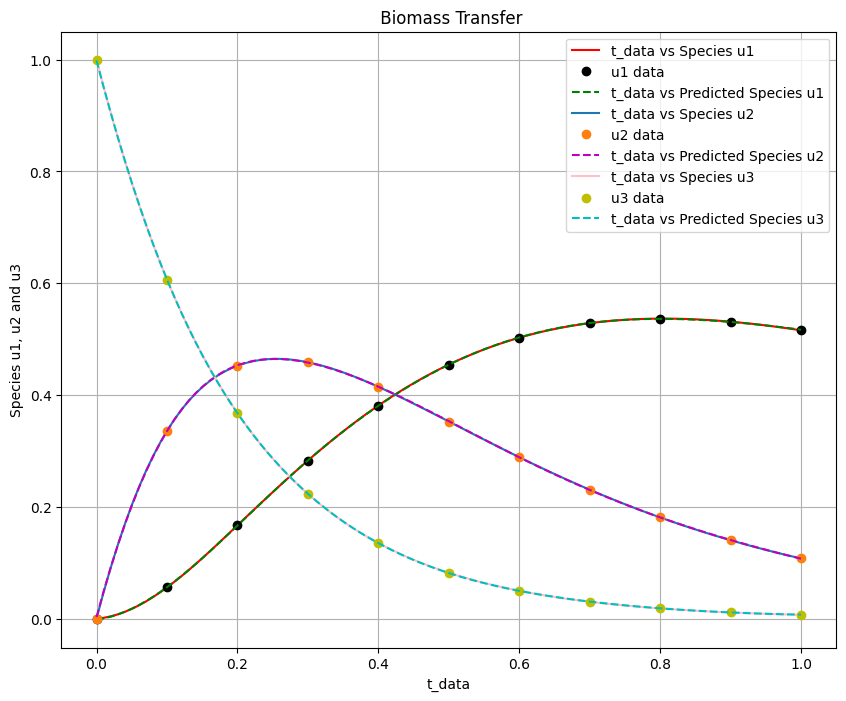

In [12]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(t_data,z1_data,'r')
plt.plot(t1_data,z11_data,'ko')
plt.plot(t_data,z1_pred,'g--')

plt.plot(t_data,z2_data,'')
plt.plot(t1_data,z21_data,'o')
plt.plot(t_data,z2_pred,'m--')

plt.plot(t_data,z3_data,'pink')
plt.plot(t1_data,z31_data,'yo')
plt.plot(t_data,z3_pred,'c--')

plt.xlabel('t_data')
plt.ylabel("Species u1, u2 and u3")
plt.grid(True)
plt.legend(["t_data vs Species u1", "u1 data", "t_data vs Predicted Species u1", "t_data vs Species u2", "u2 data", "t_data vs Predicted Species u2", "t_data vs Species u3", "u3 data", "t_data vs Predicted Species u3"])
plt.title(" Biomass Transfer")
  
plt.show()

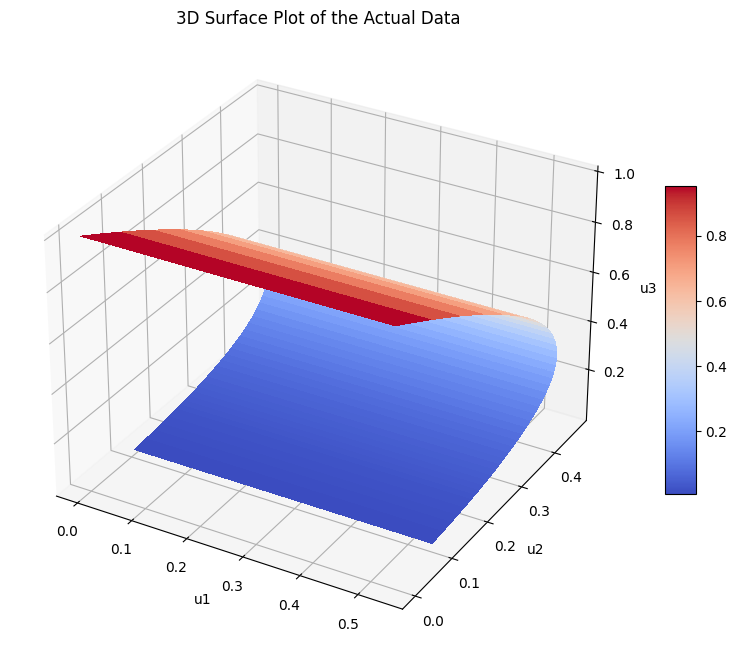

In [13]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


# Create meshgrid for u1, u2, and u3 values
U1, U2 = np.meshgrid(z1_data, z2_data)

# Create figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(U1, U2, z3_data, cmap=cm.coolwarm, antialiased=False)

# Set labels and title
ax.set_xlabel('u1')
ax.set_ylabel('u2')
ax.set_zlabel('u3')
ax.set_title('3D Surface Plot of the Actual Data')

# Add a colorbar
fig.colorbar(surf, shrink=0.5, aspect=10)

# Show the plot
plt.show()

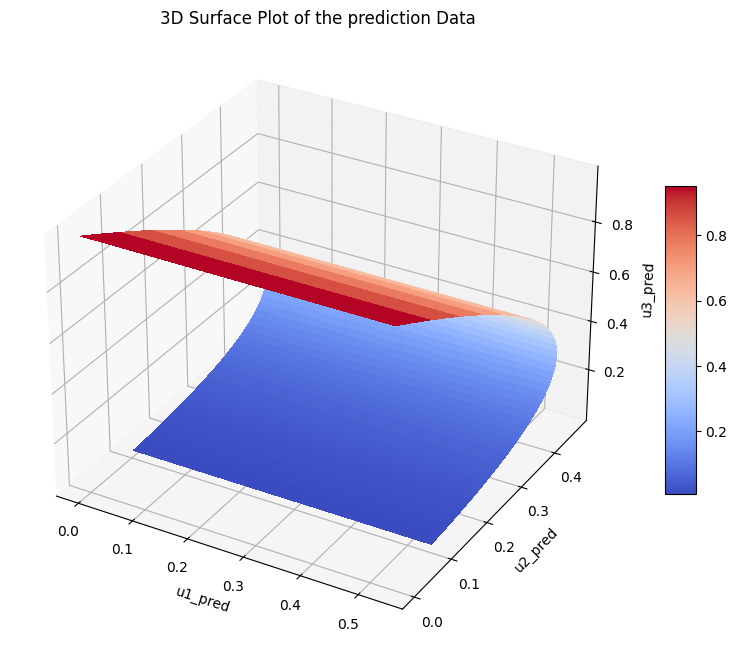

In [14]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


# Create meshgrid for u1, u2, and u3 values
U1, U2 = np.meshgrid(z1_pred, z2_pred)

# Create figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(U1, U2, z3_pred, cmap=cm.coolwarm, antialiased=False)

# Set labels and title
ax.set_xlabel('u1_pred')
ax.set_ylabel('u2_pred')
ax.set_zlabel('u3_pred')
ax.set_title('3D Surface Plot of the prediction Data')

# Add a colorbar
fig.colorbar(surf, shrink=0.5, aspect=10)

# Show the plot
plt.show()

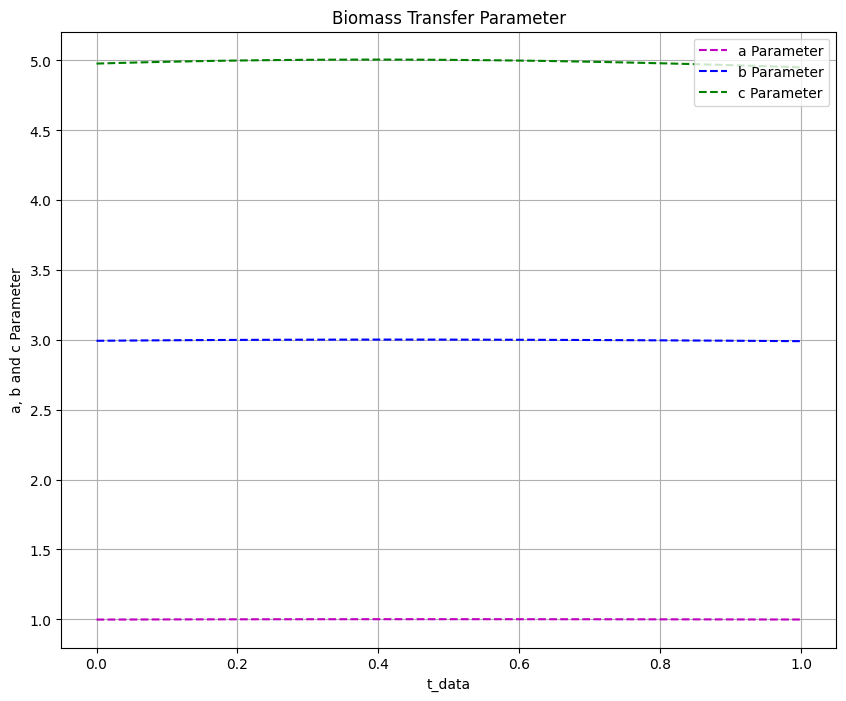

In [15]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(t_data,aa_pred,'m--')
plt.plot(t_data,bb_pred,'b--')
plt.plot(t_data,cc_pred,'g--')

plt.xlabel('t_data')
plt.ylabel("a, b and c Parameter")
plt.legend(["a Parameter", "b Parameter", "c Parameter"])
plt.grid(True)
plt.title("Biomass Transfer Parameter")
  
plt.show()

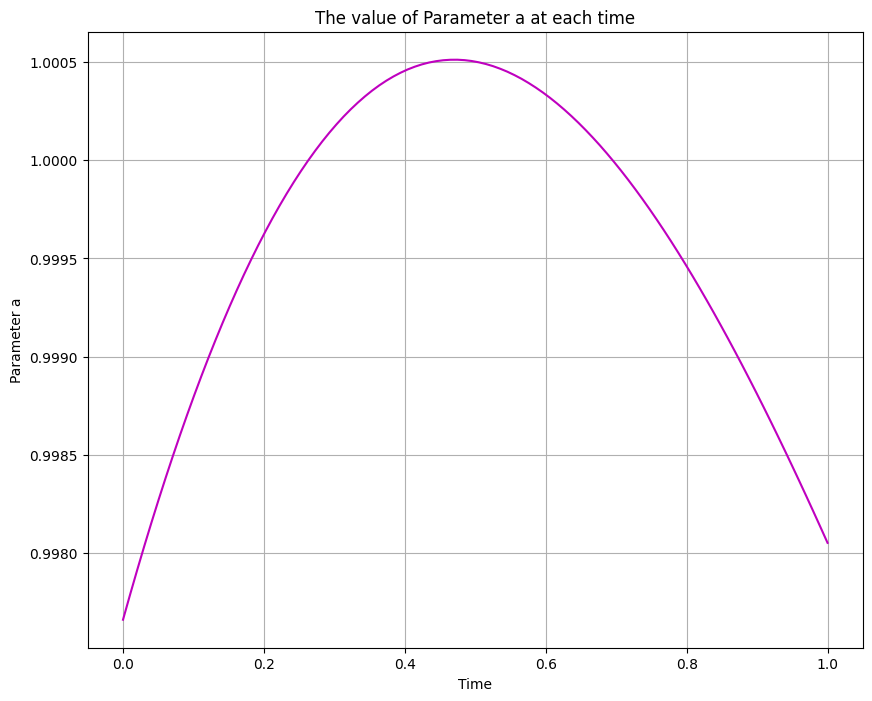

In [16]:
start_range = 0.0
end_range = 1.0

# Find the indices that correspond to the specified range
indices = [i for i, t in enumerate(t_data) if start_range <= t <= end_range]

# Extract the corresponding t_data and aa_pred values
t_data_filtered = [t_data[i] for i in indices]
aa_pred_filtered = [aa_pred[i] for i in indices]

# Plot the filtered data
plt.plot(t_data_filtered, aa_pred_filtered, "m")
plt.xlabel('Time')
plt.ylabel('Parameter a')
plt.grid(True)
plt.title('The value of Parameter a at each time')
plt.show()

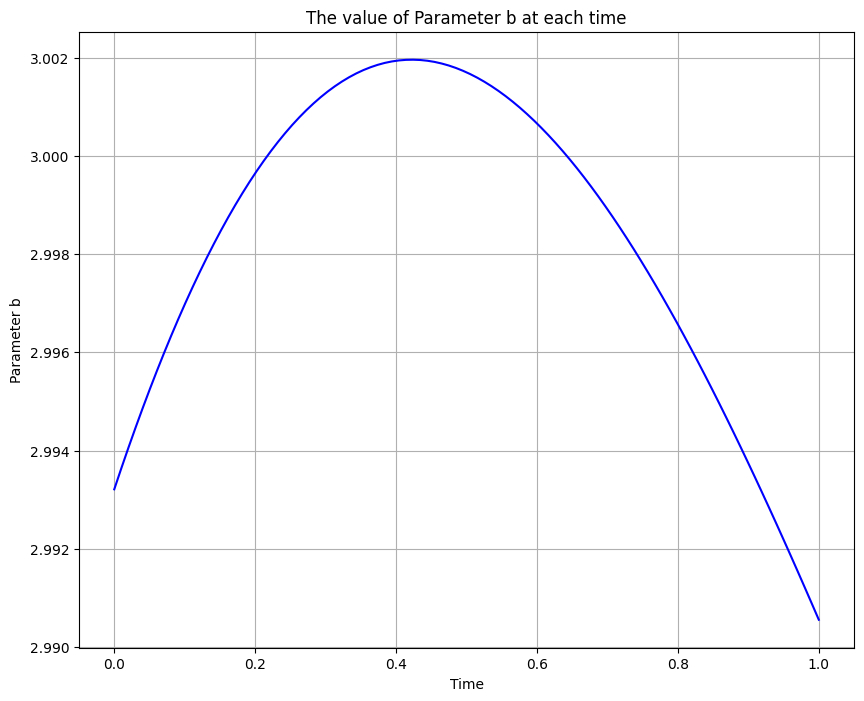

In [17]:
start_range = 0.0
end_range = 1.0

# Find the indices that correspond to the specified range
indices = [i for i, t in enumerate(t_data) if start_range <= t <= end_range]

# Extract the corresponding t_data and aa_pred values
t_data_filtered = [t_data[i] for i in indices]
bb_pred_filtered = [bb_pred[i] for i in indices]

# Plot the filtered data
plt.plot(t_data_filtered, bb_pred_filtered, "b")
plt.xlabel('Time')
plt.ylabel('Parameter b')
plt.grid(True)
plt.title('The value of Parameter b at each time')
plt.show()

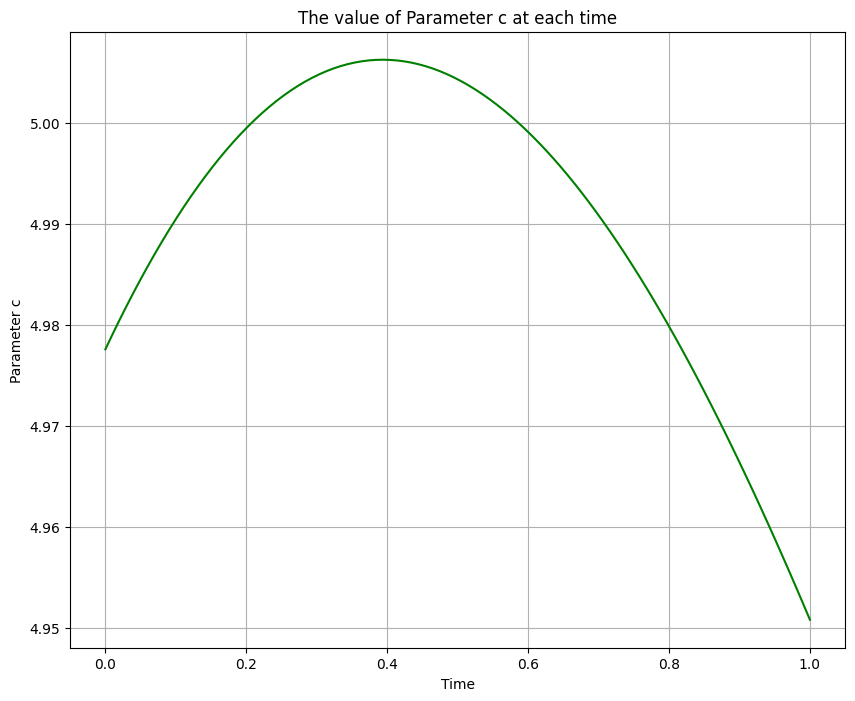

In [18]:
start_range = 0.0
end_range = 1.0

# Find the indices that correspond to the specified range
indices = [i for i, t in enumerate(t_data) if start_range <= t <= end_range]

# Extract the corresponding t_data and aa_pred values
t_data_filtered = [t_data[i] for i in indices]
cc_pred_filtered = [cc_pred[i] for i in indices]

# Plot the filtered data
plt.plot(t_data_filtered, cc_pred_filtered, "g")
plt.xlabel('Time')
plt.ylabel('Parameter c')
plt.grid(True)
plt.title('The value of Parameter c at each time')
plt.show()

In [19]:
import numpy as np

aa = 1  # initial parameter

# Using list comprehension and abs() function to calculate absolute differences
diffs = [abs(aa - i) for i in aa_pred]

# Using np.argmin() to find the index of smallest difference
index_min_diff = np.argmin(diffs)

# Getting the best predicted value
best_preda = aa_pred[index_min_diff]

# Getting the time of the best prediction
best_pred_time = t_data[index_min_diff]


# Print the best predicted value, its time step, and the actual time
print(f"The best predicted value is {best_preda} at time step {index_min_diff}, which occurred at {best_pred_time}.")

The best predicted value is [0.99999785] at time step 26, which occurred at [0.26262626].


In [20]:
import numpy as np

bb = 3  # initial parameter

# Using list comprehension and abs() function to calculate absolute differences
diffs = [abs(bb - i) for i in bb_pred]

# Using np.argmin() to find the index of smallest difference
index_min_diff = np.argmin(diffs)

# Getting the best predicted value
best_predb = bb_pred[index_min_diff]

# Getting the time of the best prediction
best_pred_time = t_data[index_min_diff]


# Print the best predicted value, its time step, and the actual time
print(f"The best predicted value is {best_predb} at time step {index_min_diff}, which occurred at {best_pred_time}.")

The best predicted value is [2.999931] at time step 64, which occurred at [0.64646465].


In [21]:
import numpy as np

cc = 5  # initial parameter

# Using list comprehension and abs() function to calculate absolute differences
diffs = [abs(cc - i) for i in cc_pred]

# Using np.argmin() to find the index of smallest difference
index_min_diff = np.argmin(diffs)

# Getting the best predicted value
best_predc = cc_pred[index_min_diff]

# Getting the time of the best prediction
best_pred_time = t_data[index_min_diff]


# Print the best predicted value, its time step, and the actual time
print(f"The best predicted value is {best_predc} at time step {index_min_diff}, which occurred at {best_pred_time}.")

The best predicted value is [5.000046] at time step 58, which occurred at [0.58585859].


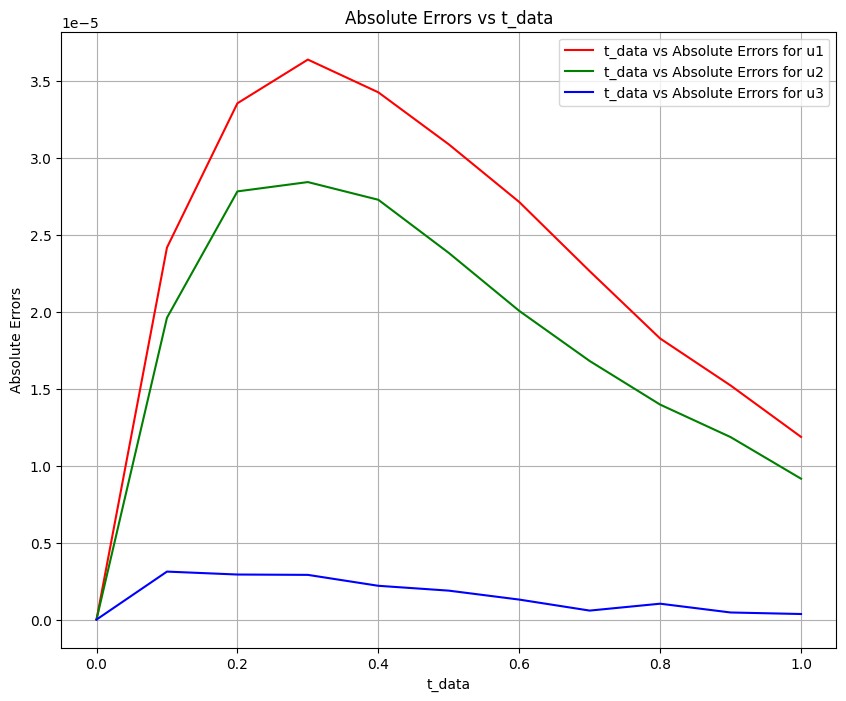

In [22]:
k1 = best_preda[0] # If best_preda is a one-dimensional array
k2 = best_predb[0]  # If best_predb is a one-dimensional array
k3 = best_predc[0]  # If best_predc is a one-dimensional array

t = np.array(dat1["t"]).flatten()

# Compute exact solutions with the learned parameters
u1_pred = 15/8 * (np.exp(-k3 * t) - 2 * np.exp(-k2 * t) + np.exp(-k1 * t))
u2_pred = 5 / 2 * (- np.exp(-k3 * t) + np.exp(-k2 * t))
u3_pred = np.exp(-k3 * t)


u1_u2 = np.hstack((z1_new, z2_new, z3_new))



# plot the absolute errors between the target and the predictions (make sure u1_u2 and t are defined properly)
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(t_new, np.abs(u1_u2[:, 0] - u1_pred), 'r')
plt.plot(t_new, np.abs(u1_u2[:, 1] - u2_pred), 'g')
plt.plot(t_new, np.abs(u1_u2[:, 2] - u3_pred), 'b')
plt.xlabel('t_data')
plt.ylabel("Absolute Errors")
plt.legend(["t_data vs Absolute Errors for u1", "t_data vs Absolute Errors for u2", "t_data vs Absolute Errors for u3"])
plt.grid(True)
plt.title("Absolute Errors vs t_data")
plt.show()


Loss: 0.00014833294


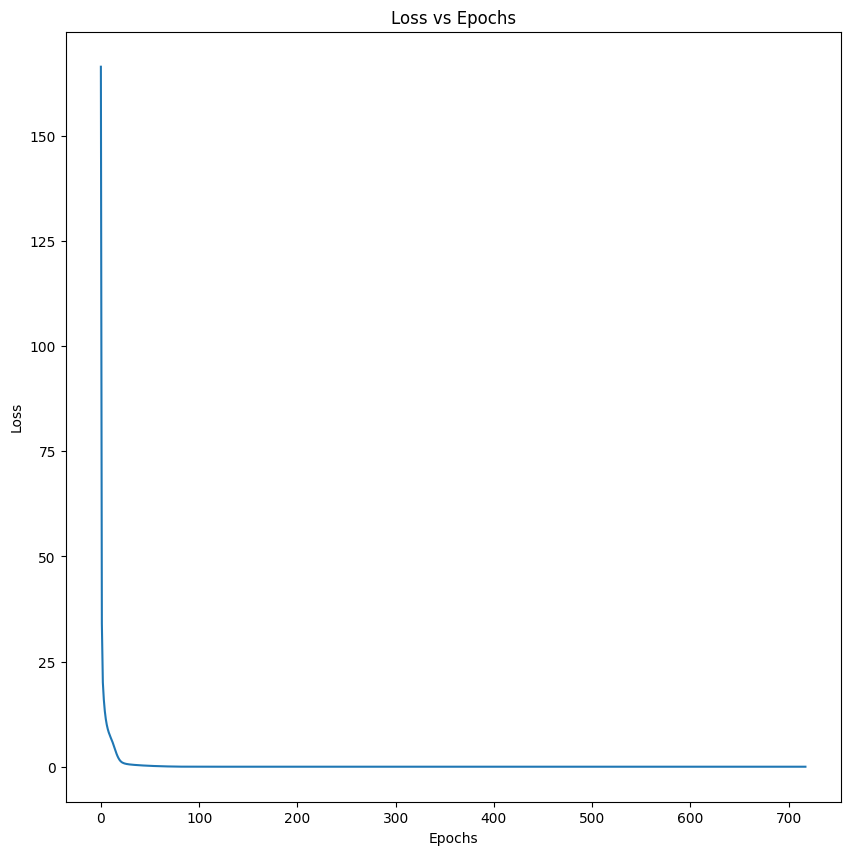

R-squared for u1: 0.999999982579334
R-squared for u2: 0.9999999806866591
R-squared for u3: 0.9999999999614793
Mean absolute error for u1: 2.3117525863277062e-05
Mean absolute error for u2: 1.806806932975898e-05
Mean absolute error for u3: 1.5236587129152973e-06
Mean squared error for u1: 6.465163936997516e-10
Mean squared error for u2: 3.9820567133041316e-10
Mean squared error for u3: 3.5002748067452632e-12
Root mean squared error for u1: 2.542668664414913e-05
Root mean squared error for u2: 1.9955091363619793e-05
Root mean squared error for u3: 1.8709021371373927e-06
Explained variance score for u1: 0.9999999969795139
Explained variance score for u2: 0.9999999965200328
Explained variance score for u3: 0.9999999999870279


In [23]:
# calculate the loss
loss = model.sess.run(model.loss, {model.t_tf: t_data, model.z1_tf: z1_data, model.z2_tf: z2_data, model.z3_tf: z3_data})
print("Loss:", loss)

# plot the loss
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(model.loss_log)
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()

# calculate the R-squared
from sklearn.metrics import r2_score
r2_u1 = r2_score(u1_u2[:, 0], u1_pred)
r2_u2 = r2_score(u1_u2[:, 1], u2_pred)
r3_u3 = r2_score(u1_u2[:, 2], u3_pred)
print(f"R-squared for u1: {r2_u1}")
print(f"R-squared for u2: {r2_u2}")
print(f"R-squared for u3: {r3_u3}")

# calculate the mean absolute error
from sklearn.metrics import mean_absolute_error
mae_u1 = mean_absolute_error(u1_u2[:, 0], u1_pred)
mae_u2 = mean_absolute_error(u1_u2[:, 1], u2_pred)
mae_u3 = mean_absolute_error(u1_u2[:, 2], u3_pred)
print(f"Mean absolute error for u1: {mae_u1}")
print(f"Mean absolute error for u2: {mae_u2}")
print(f"Mean absolute error for u3: {mae_u3}")

# calculate the mean squared error
from sklearn.metrics import mean_squared_error
mse_u1 = mean_squared_error(u1_u2[:, 0], u1_pred)
mse_u2 = mean_squared_error(u1_u2[:, 1], u2_pred)
mse_u3 = mean_squared_error(u1_u2[:, 2], u3_pred)
print(f"Mean squared error for u1: {mse_u1}")
print(f"Mean squared error for u2: {mse_u2}")
print(f"Mean squared error for u3: {mse_u3}")

# calculate the root mean squared error
from sklearn.metrics import mean_squared_error
rmse_u1 = mean_squared_error(u1_u2[:, 0], u1_pred, squared=False)
rmse_u2 = mean_squared_error(u1_u2[:, 1], u2_pred, squared=False)
rmse_u3 = mean_squared_error(u1_u2[:, 2], u3_pred, squared=False)
print(f"Root mean squared error for u1: {rmse_u1}")
print(f"Root mean squared error for u2: {rmse_u2}")
print(f"Root mean squared error for u3: {rmse_u3}")


# calculate the Explained variance score
from sklearn.metrics import explained_variance_score
evs_u1 = explained_variance_score(u1_u2[:, 0], u1_pred)
evs_u2 = explained_variance_score(u1_u2[:, 1], u2_pred)
evs_u3 = explained_variance_score(u1_u2[:, 2], u3_pred)
print(f"Explained variance score for u1: {evs_u1}")
print(f"Explained variance score for u2: {evs_u2}")
print(f"Explained variance score for u3: {evs_u3}")


--------------

In [24]:
niter = 20000  # number of Epochs
layers = [1, 40, 3]
layers1 = [1, 40, 1]
layers2 = [1, 40, 1]
layers3 = [1, 40, 1]

model = PINN(t_data, z1_data, z2_data, z3_data, layers, layers1, layers2, layers3)
model.train(niter)


Device mapping: no known devices.


2023-08-08 12:37:44.618386: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-08-08 12:37:44.988357: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
2023-08-08 12:37:44.988390: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
2023-08-08 12:37:44.988394: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
2023-08-08 12:37:44.988398: I tensorflow/core/common_runtime/placer.cc:114] Variable: (VariableV2): /job:localhost/replica:0/task:0/de

sk:0/device:CPU:0
Variable_15/Adam_1/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Adam/learning_rate: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Adam/beta1: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Adam/beta2: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Adam/epsilon: (Const): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Variable/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/rea

100%|██████████| 20000/20000 [00:09<00:00, 2083.22it/s]


In [25]:
# prediction
z1_pred, z2_pred, z3_pred, aa_pred, bb_pred, cc_pred = model.predict(t_data)

In [26]:
import numpy as np

aa = 1  # initial parameter

# Using list comprehension and abs() function to calculate absolute differences
diffs = [abs(aa - i) for i in aa_pred]

# Using np.argmin() to find the index of smallest difference
index_min_diff = np.argmin(diffs)

# Getting the best predicted value
best_pred = aa_pred[index_min_diff]

# Getting the time of the best prediction
best_pred_time = t_data[index_min_diff]


# Print the best predicted value, its time step, and the actual time
print(f"The best predicted value is {best_pred} at time step {index_min_diff}, which occurred at {best_pred_time}.")

The best predicted value is [1.0000379] at time step 27, which occurred at [0.27272727].


In [27]:
import numpy as np

bb = 3  # initial parameter

# Using list comprehension and abs() function to calculate absolute differences
diffs = [abs(bb - i) for i in bb_pred]

# Using np.argmin() to find the index of smallest difference
index_min_diff = np.argmin(diffs)

# Getting the best predicted value
best_predb = bb_pred[index_min_diff]

# Getting the time of the best prediction
best_pred_time = t_data[index_min_diff]


# Print the best predicted value, its time step, and the actual time
print(f"The best predicted value is {best_predb} at time step {index_min_diff}, which occurred at {best_pred_time}.")

The best predicted value is [3.0000386] at time step 65, which occurred at [0.65656566].


In [28]:
import numpy as np

cc = 5  # initial parameter

# Using list comprehension and abs() function to calculate absolute differences
diffs = [abs(cc - i) for i in cc_pred]

# Using np.argmin() to find the index of smallest difference
index_min_diff = np.argmin(diffs)

# Getting the best predicted value
best_predc = cc_pred[index_min_diff]

# Getting the time of the best prediction
best_pred_time = t_data[index_min_diff]


# Print the best predicted value, its time step, and the actual time
print(f"The best predicted value is {best_predc} at time step {index_min_diff}, which occurred at {best_pred_time}.")

The best predicted value is [5.0002103] at time step 59, which occurred at [0.5959596].


Loss: 0.0015907089


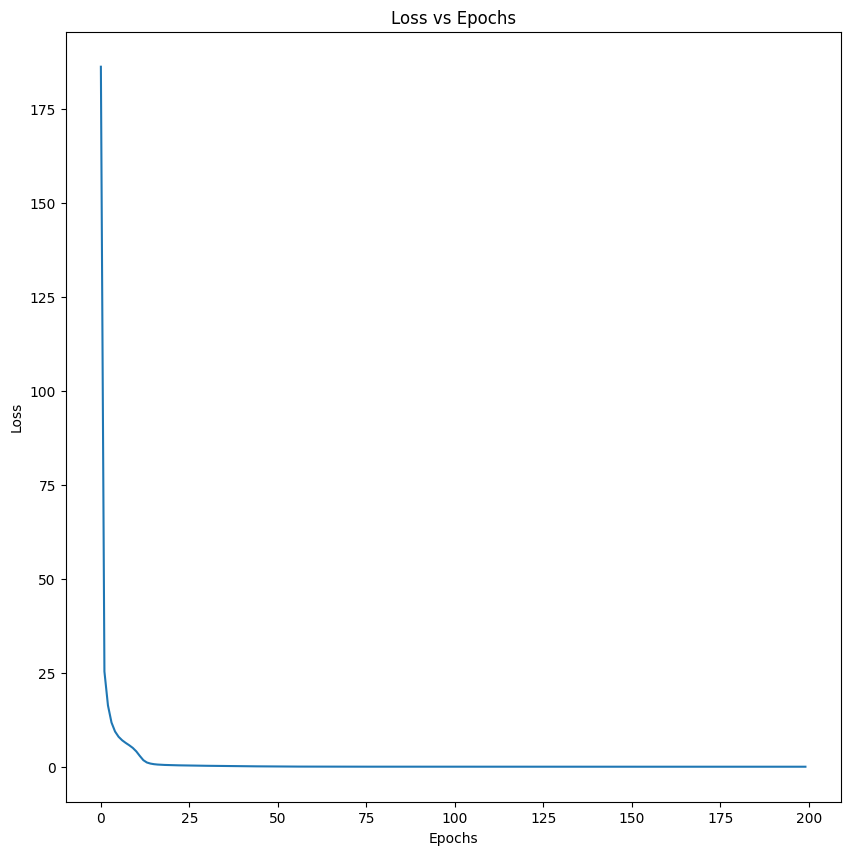

R^2 score for z1: 0.9999546542170272
R^2 score for z2: 0.999667890614371
R^2 score for z3: 0.9999670185481467
MSE for z1: 1.5182570933888618e-06
MSE for z2: 5.132363966289555e-06
MSE for z3: 2.0925554977282386e-06
MAE for z1: 0.0010112224737335244
MAE for z2: 0.0016962981643548816
MAE for z3: 0.0011077175877929183
EVS for z1: 0.9999566680022688
EVS for z2: 0.9996750772525996
EVS for z3: 0.9999719235684218
RMSE for z1: 0.0012321757558842253
RMSE for z2: 0.002265472128782333
RMSE for z3: 0.001446566796842869


In [29]:
# calculate the loss
loss = model.sess.run(model.loss, {model.t_tf: t_data, model.z1_tf: z1_data, model.z2_tf: z2_data, model.z3_tf: z3_data})
print("Loss:", loss)

# plot the loss
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(model.loss_log)
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()

# calculate the R^2 score
from sklearn.metrics import r2_score
r2_z1 = r2_score(z1_data, z1_pred)
r2_z2 = r2_score(z2_data, z2_pred)
r2_z3 = r2_score(z3_data, z3_pred)
print("R^2 score for z1:", r2_z1)
print("R^2 score for z2:", r2_z2)
print("R^2 score for z3:", r2_z3)

# calculate the mean squared error
from sklearn.metrics import mean_squared_error
mse_z1 = mean_squared_error(z1_data, z1_pred)
mse_z2 = mean_squared_error(z2_data, z2_pred)
mse_z3 = mean_squared_error(z3_data, z3_pred)
print("MSE for z1:", mse_z1)
print("MSE for z2:", mse_z2)
print("MSE for z3:", mse_z3)

# calculate the mean absolute error
from sklearn.metrics import mean_absolute_error
mae_z1 = mean_absolute_error(z1_data, z1_pred)
mae_z2 = mean_absolute_error(z2_data, z2_pred)
mae_z3 = mean_absolute_error(z3_data, z3_pred)
print("MAE for z1:", mae_z1)
print("MAE for z2:", mae_z2)
print("MAE for z3:", mae_z3)



# calculate the Explained Variance Score
from sklearn.metrics import explained_variance_score
evs_z1 = explained_variance_score(z1_data, z1_pred)
evs_z2 = explained_variance_score(z2_data, z2_pred)
evs_z3 = explained_variance_score(z3_data, z3_pred)
print("EVS for z1:", evs_z1)
print("EVS for z2:", evs_z2)
print("EVS for z3:", evs_z3)

# calculate the root mean squared error
from sklearn.metrics import mean_squared_error
rmse_z1 = mean_squared_error(z1_data, z1_pred, squared=False)
rmse_z2 = mean_squared_error(z2_data, z2_pred, squared=False)
rmse_z3 = mean_squared_error(z3_data, z3_pred, squared=False)
print("RMSE for z1:", rmse_z1)
print("RMSE for z2:", rmse_z2)
print("RMSE for z3:", rmse_z3)




--------------

In [30]:
niter = 15107  # number of Epochs
layers = [1, 40, 40, 3]
layers1 = [1, 40, 40, 1]
layers2 = [1, 40, 40, 1]
layers3 = [1, 40, 40, 1]

model = PINN(t_data, z1_data, z2_data, z3_data, layers, layers1, layers2, layers3)
model.train(niter)


Device mapping: no known devices.


2023-08-08 12:37:54.968347: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-08-08 12:37:55.441498: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
2023-08-08 12:37:55.441530: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
2023-08-08 12:37:55.441534: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
2023-08-08 12:37:55.441538: I tensorflow/core/common_runtime/placer.cc:114] Variable: (VariableV2): /job:localhost/replica:0/task:0/de

ica:0/task:0/device:CPU:0
Variable_22/Adam_1/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_23/Adam/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_23/Adam_1/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_24/Adam/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_24/Adam_1/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_25/Adam/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_25/Adam_1/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_26/Adam/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_26/Adam_1/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_27/Adam/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_27/Adam_1/Initializer/zeros: (Const): /job:localhost/re

100%|██████████| 15107/15107 [00:09<00:00, 1648.42it/s]


In [31]:
# prediction
z1_pred, z2_pred, z3_pred, aa_pred, bb_pred, cc_pred = model.predict(t_data)

In [32]:
import numpy as np

aa = 1  # initial parameter

# Using list comprehension and abs() function to calculate absolute differences
diffs = [abs(aa - i) for i in aa_pred]

# Using np.argmin() to find the index of smallest difference
index_min_diff = np.argmin(diffs)

# Getting the best predicted value
best_pred = aa_pred[index_min_diff]

# Getting the time of the best prediction
best_pred_time = t_data[index_min_diff]


# Print the best predicted value, its time step, and the actual time
print(f"The best predicted value is {best_pred} at time step {index_min_diff}, which occurred at {best_pred_time}.")

The best predicted value is [1.0000603] at time step 66, which occurred at [0.66666667].


In [33]:
import numpy as np

bb = 3  # initial parameter

# Using list comprehension and abs() function to calculate absolute differences
diffs = [abs(bb - i) for i in bb_pred]

# Using np.argmin() to find the index of smallest difference
index_min_diff = np.argmin(diffs)

# Getting the best predicted value
best_predb = bb_pred[index_min_diff]

# Getting the time of the best prediction
best_pred_time = t_data[index_min_diff]


# Print the best predicted value, its time step, and the actual time
print(f"The best predicted value is {best_predb} at time step {index_min_diff}, which occurred at {best_pred_time}.")

The best predicted value is [2.9999495] at time step 24, which occurred at [0.24242424].


In [34]:
import numpy as np

cc = 5  # initial parameter

# Using list comprehension and abs() function to calculate absolute differences
diffs = [abs(cc - i) for i in cc_pred]

# Using np.argmin() to find the index of smallest difference
index_min_diff = np.argmin(diffs)

# Getting the best predicted value
best_predc = cc_pred[index_min_diff]

# Getting the time of the best prediction
best_pred_time = t_data[index_min_diff]


# Print the best predicted value, its time step, and the actual time
print(f"The best predicted value is {best_predc} at time step {index_min_diff}, which occurred at {best_pred_time}.")

The best predicted value is [4.9998903] at time step 68, which occurred at [0.68686869].


Loss: 0.0038743336


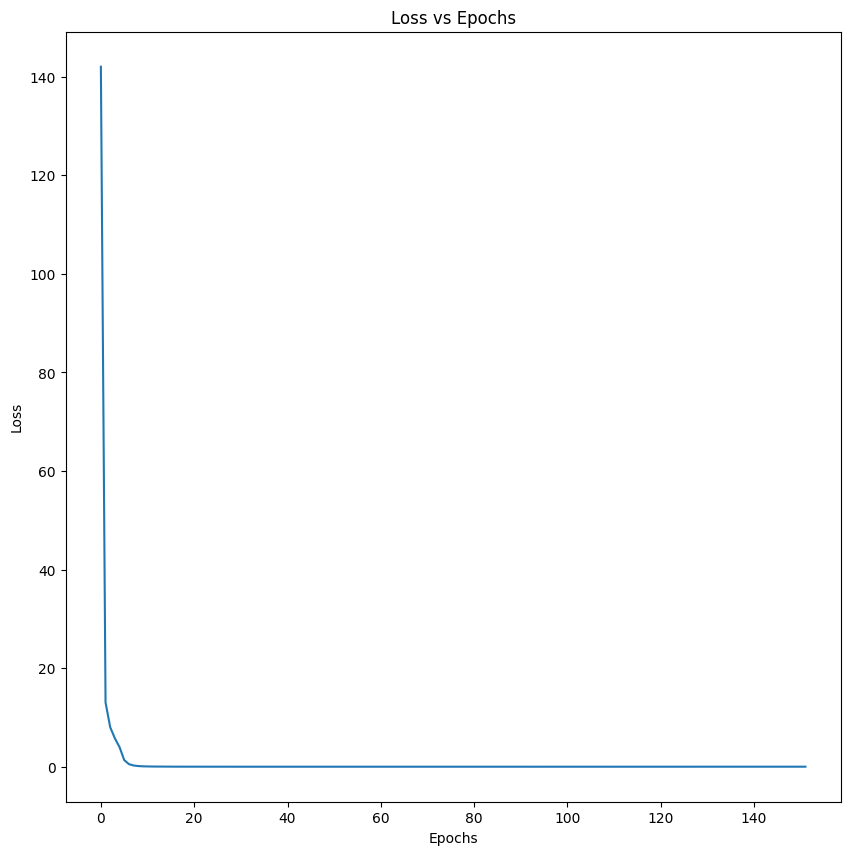

R^2 score for z1: 0.9999167876879359
R^2 score for z2: 0.9997914532859479
R^2 score for z3: 0.9999476681104628
MSE for z1: 2.7860955256739033e-06
MSE for z2: 3.222846708960271e-06
MSE for z3: 3.3202717589528283e-06
MAE for z1: 0.0014953574893665671
MAE for z2: 0.0016688704264291162
MAE for z3: 0.0015825956977018566
EVS for z1: 0.9999831648617623
EVS for z2: 0.9999716757567582
EVS for z3: 0.9999850169968976
RMSE for z1: 0.0016691601258339186
RMSE for z2: 0.0017952288736983568
RMSE for z3: 0.0018221612878537477


In [35]:
# calculate the loss
loss = model.sess.run(model.loss, {model.t_tf: t_data, model.z1_tf: z1_data, model.z2_tf: z2_data, model.z3_tf: z3_data})
print("Loss:", loss)

# plot the loss
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(model.loss_log)
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()

# calculate the R^2 score
from sklearn.metrics import r2_score
r2_z1 = r2_score(z1_data, z1_pred)
r2_z2 = r2_score(z2_data, z2_pred)
r2_z3 = r2_score(z3_data, z3_pred)
print("R^2 score for z1:", r2_z1)
print("R^2 score for z2:", r2_z2)
print("R^2 score for z3:", r2_z3)

# calculate the mean squared error
from sklearn.metrics import mean_squared_error
mse_z1 = mean_squared_error(z1_data, z1_pred)
mse_z2 = mean_squared_error(z2_data, z2_pred)
mse_z3 = mean_squared_error(z3_data, z3_pred)
print("MSE for z1:", mse_z1)
print("MSE for z2:", mse_z2)
print("MSE for z3:", mse_z3)

# calculate the mean absolute error
from sklearn.metrics import mean_absolute_error
mae_z1 = mean_absolute_error(z1_data, z1_pred)
mae_z2 = mean_absolute_error(z2_data, z2_pred)
mae_z3 = mean_absolute_error(z3_data, z3_pred)
print("MAE for z1:", mae_z1)
print("MAE for z2:", mae_z2)
print("MAE for z3:", mae_z3)



# calculate the Explained Variance Score
from sklearn.metrics import explained_variance_score
evs_z1 = explained_variance_score(z1_data, z1_pred)
evs_z2 = explained_variance_score(z2_data, z2_pred)
evs_z3 = explained_variance_score(z3_data, z3_pred)
print("EVS for z1:", evs_z1)
print("EVS for z2:", evs_z2)
print("EVS for z3:", evs_z3)

# calculate the root mean squared error
from sklearn.metrics import mean_squared_error
rmse_z1 = mean_squared_error(z1_data, z1_pred, squared=False)
rmse_z2 = mean_squared_error(z2_data, z2_pred, squared=False)
rmse_z3 = mean_squared_error(z3_data, z3_pred, squared=False)
print("RMSE for z1:", rmse_z1)
print("RMSE for z2:", rmse_z2)
print("RMSE for z3:", rmse_z3)




--------------

In [36]:
niter = 9800  # number of Epochs
layers = [1, 40, 40, 40, 3]
layers1 = [1, 40, 40, 40, 1]
layers2 = [1, 40, 40, 40, 1]
layers3 = [1, 40, 40, 40,  1]

model = PINN(t_data, z1_data, z2_data, z3_data, layers, layers1, layers2, layers3)
model.train(niter)


Device mapping: no known devices.


2023-08-08 12:38:05.098460: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-08-08 12:38:05.826545: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
2023-08-08 12:38:05.826583: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
2023-08-08 12:38:05.826588: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
2023-08-08 12:38:05.826592: I tensorflow/core/common_runtime/placer.cc:114] Variable: (VariableV2): /job:localhost/replica:0/task:0/de

tializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_53/Adam_1/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_54/Adam/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_54/Adam_1/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_55/Adam/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_55/Adam_1/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Adam_2/learning_rate: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Adam_2/beta1: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Adam_2/beta2: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Adam_2/epsilon: (Const): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal: (A

100%|██████████| 9800/9800 [00:06<00:00, 1414.61it/s]


In [37]:
# prediction
z1_pred, z2_pred, z3_pred, aa_pred, bb_pred, cc_pred = model.predict(t_data)

In [38]:
import numpy as np

aa = 1  # initial parameter

# Using list comprehension and abs() function to calculate absolute differences
diffs = [abs(aa - i) for i in aa_pred]

# Using np.argmin() to find the index of smallest difference
index_min_diff = np.argmin(diffs)

# Getting the best predicted value
best_pred = aa_pred[index_min_diff]

# Getting the time of the best prediction
best_pred_time = t_data[index_min_diff]


# Print the best predicted value, its time step, and the actual time
print(f"The best predicted value is {best_pred} at time step {index_min_diff}, which occurred at {best_pred_time}.")

The best predicted value is [0.99996376] at time step 82, which occurred at [0.82828283].


In [39]:
import numpy as np

bb = 3  # initial parameter

# Using list comprehension and abs() function to calculate absolute differences
diffs = [abs(bb - i) for i in bb_pred]

# Using np.argmin() to find the index of smallest difference
index_min_diff = np.argmin(diffs)

# Getting the best predicted value
best_predb = bb_pred[index_min_diff]

# Getting the time of the best prediction
best_pred_time = t_data[index_min_diff]


# Print the best predicted value, its time step, and the actual time
print(f"The best predicted value is {best_predb} at time step {index_min_diff}, which occurred at {best_pred_time}.")

The best predicted value is [3.000064] at time step 32, which occurred at [0.32323232].


In [40]:
import numpy as np

cc = 5  # initial parameter

# Using list comprehension and abs() function to calculate absolute differences
diffs = [abs(cc - i) for i in cc_pred]

# Using np.argmin() to find the index of smallest difference
index_min_diff = np.argmin(diffs)

# Getting the best predicted value
best_predc = cc_pred[index_min_diff]

# Getting the time of the best prediction
best_pred_time = t_data[index_min_diff]


# Print the best predicted value, its time step, and the actual time
print(f"The best predicted value is {best_predc} at time step {index_min_diff}, which occurred at {best_pred_time}.")

The best predicted value is [4.999971] at time step 68, which occurred at [0.68686869].


Loss: 0.00019654559


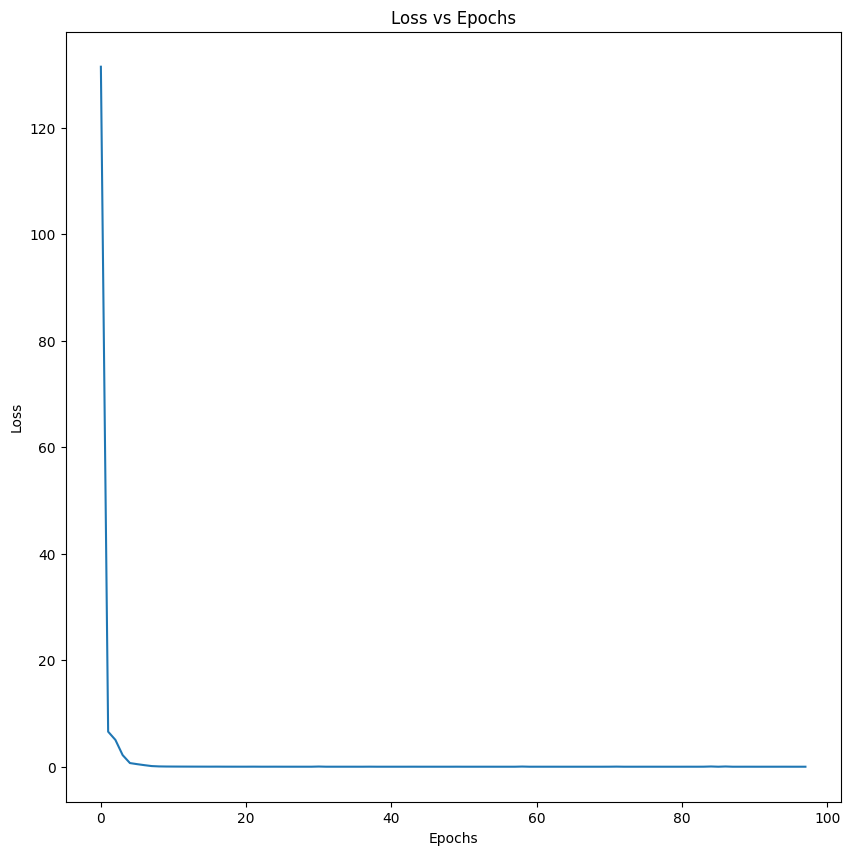

R^2 score for z1: 0.9999889200377541
R^2 score for z2: 0.9999792034438597
R^2 score for z3: 0.9999974290036379
MSE for z1: 3.709767517849843e-07
MSE for z2: 3.2138656712502713e-07
MSE for z3: 1.6312055018560544e-07
MAE for z1: 0.000462550313725931
MAE for z2: 0.00044046679951550413
MAE for z3: 0.00030470143438275817
EVS for z1: 0.9999889226063723
EVS for z2: 0.9999792871972029
EVS for z3: 0.9999975024402091
RMSE for z1: 0.0006090786088716171
RMSE for z2: 0.0005669096639897993
RMSE for z3: 0.00040388185176559423


In [41]:
# calculate the loss
loss = model.sess.run(model.loss, {model.t_tf: t_data, model.z1_tf: z1_data, model.z2_tf: z2_data, model.z3_tf: z3_data})
print("Loss:", loss)

# plot the loss
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(model.loss_log)
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()

# calculate the R^2 score
from sklearn.metrics import r2_score
r2_z1 = r2_score(z1_data, z1_pred)
r2_z2 = r2_score(z2_data, z2_pred)
r2_z3 = r2_score(z3_data, z3_pred)
print("R^2 score for z1:", r2_z1)
print("R^2 score for z2:", r2_z2)
print("R^2 score for z3:", r2_z3)

# calculate the mean squared error
from sklearn.metrics import mean_squared_error
mse_z1 = mean_squared_error(z1_data, z1_pred)
mse_z2 = mean_squared_error(z2_data, z2_pred)
mse_z3 = mean_squared_error(z3_data, z3_pred)
print("MSE for z1:", mse_z1)
print("MSE for z2:", mse_z2)
print("MSE for z3:", mse_z3)

# calculate the mean absolute error
from sklearn.metrics import mean_absolute_error
mae_z1 = mean_absolute_error(z1_data, z1_pred)
mae_z2 = mean_absolute_error(z2_data, z2_pred)
mae_z3 = mean_absolute_error(z3_data, z3_pred)
print("MAE for z1:", mae_z1)
print("MAE for z2:", mae_z2)
print("MAE for z3:", mae_z3)



# calculate the Explained Variance Score
from sklearn.metrics import explained_variance_score
evs_z1 = explained_variance_score(z1_data, z1_pred)
evs_z2 = explained_variance_score(z2_data, z2_pred)
evs_z3 = explained_variance_score(z3_data, z3_pred)
print("EVS for z1:", evs_z1)
print("EVS for z2:", evs_z2)
print("EVS for z3:", evs_z3)

# calculate the root mean squared error
from sklearn.metrics import mean_squared_error
rmse_z1 = mean_squared_error(z1_data, z1_pred, squared=False)
rmse_z2 = mean_squared_error(z2_data, z2_pred, squared=False)
rmse_z3 = mean_squared_error(z3_data, z3_pred, squared=False)
print("RMSE for z1:", rmse_z1)
print("RMSE for z2:", rmse_z2)
print("RMSE for z3:", rmse_z3)


